In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import os
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime
from datetime import date, timedelta
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

data_path = 'D:/universidad/universidad 4/TFG/recursos para el desarrollo/datos procesados/OD'

In [2]:
delta = e_date - i_date

target_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    target_days.append(day)

In [3]:
def read_OD_fn(source_type):
    ods = {}
    for date in tqdm_notebook(target_days):
        od_date= pd.read_csv(os.path.join(data_path, 'date_{}_OD_{}.csv'.format(source_type,date.strftime('%Y-%m-%d'))), 
                            index_col=0)
        ods[date] = od_date
    return ods

In [4]:
ine_ods = read_OD_fn('INE')

  0%|          | 0/81 [00:00<?, ?it/s]

# Serializar los datos

In [5]:
lista = []

for date in tqdm_notebook(target_days):
    lista.append(ine_ods[date].loc['total','total'])
    
del ine_ods

  0%|          | 0/81 [00:00<?, ?it/s]

In [6]:
df = pd.DataFrame (lista, columns = ['Viajes'], index= target_days)

In [7]:
df.head()

,Viajes
2020-04-01,2213123
2020-04-02,2254121
2020-04-03,2520095
2020-04-04,1934554
2020-04-05,1593385


# Visualización de datos

In [8]:
print(df.index.min())
print(df.index.max())

2020-04-01 00:00:00
2020-06-20 00:00:00


In [9]:
print(len(df['2020']))

81


In [10]:
df.describe()

,Viajes
count,8.100000e+01
mean,3.438222e+06
std,1.174931e+06
min,1.535886e+06
25%,2.488436e+06
50%,3.396402e+06
75%,4.445190e+06
max,5.519725e+06


In [11]:
meses = df.resample('M').mean()
meses

,Viajes
2020-04-30,2.356878e+06
2020-05-31,3.590722e+06
2020-06-30,4.823862e+06


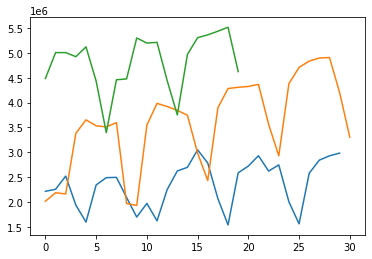

In [12]:
abril = df['2020-04-01':'2020-04-30']
plt.plot(abril.values)
mayo = df['2020-05-01':'2020-05-31']
plt.plot(mayo.values)
junio = df['2020-06-01':'2020-06-20']
plt.plot(junio.values)

# Preprocesado de datos

In [13]:
# cantidad de dias previos que se usaran para predecir el siguiente dia 
look_back=7

# convertir series en conocimiento supervisado
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # secuencia de entrada (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # secuencia del pronostico (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # unimos todo
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # eliminamos todos los valores nulos
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# cargamos el dataframe en la variable values
values = df.values

# convertimos los enteros en floats
values = values.astype('float32')

# normalizamos los datos a escala de entre -1 y 1
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

# usamos la funcion definida previamente
reframed = series_to_supervised(scaled, look_back, 1)

# imprimimos los nuevos datos
reframed.tail()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
76,0.477061,0.891413,0.839957,0.847171,0.460553,0.113062,0.725623,0.894152
77,0.891413,0.839957,0.847171,0.460553,0.113062,0.725623,0.894152,0.923149
78,0.839957,0.847171,0.460553,0.113062,0.725623,0.894152,0.923149,0.959687
79,0.847171,0.460553,0.113062,0.725623,0.894152,0.923149,0.959687,1.000000
80,0.460553,0.113062,0.725623,0.894152,0.923149,0.959687,1.000000,0.551599


# Dividimos los datos en sets de entrenamiento y validacion

In [14]:
# dividimos nuestro valores entre sets de entrenamiento y de test
values = reframed.values
n_train_days = 71 - (10+look_back)
train = values[:n_train_days, :]
test = values[n_train_days:, :]

# los volvemos a dividir en entradas y salidas
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]

# remodelamos la muestras para ser de las dimensiones [samples, timesteps, features]
trainX = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
testX = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))

print(trainX.shape, y_train.shape, testX.shape, y_val.shape)

(54, 1, 7) (54,) (20, 1, 7) (20,)


# Creamos la red neuronal

In [15]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(look_back, input_shape=(1,look_back),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(100, activation='tanh'))
    model.add(Dropout(0.30))
    model.add(Dense(100, activation='tanh'))
    model.add(Dropout(0.30))
    model.add(Dense(100, activation='tanh'))
    model.add(Dropout(0.30))
    model.add(Dense(100, activation='tanh'))
    model.add(Dropout(0.30))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [16]:
EPOCHS=200

model = crear_modeloFF()

history=model.fit(trainX,y_train,epochs=EPOCHS,validation_data=(testX,y_val),batch_size=look_back)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 7)              56        
_________________________________________________________________
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               800       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               1

8/8 [==============================] - 0s 6ms/step - loss: 0.1660 - mse: 0.0462 - val_loss: 0.1538 - val_mse: 0.0386
Epoch 50/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1638 - mse: 0.0469 - val_loss: 0.1621 - val_mse: 0.0444
Epoch 51/200
8/8 [==============================] - ETA: 0s - loss: 0.2963 - mse: 0.128 - 0s 6ms/step - loss: 0.2298 - mse: 0.0867 - val_loss: 0.1500 - val_mse: 0.0367
Epoch 52/200
8/8 [==============================] - 0s 6ms/step - loss: 0.1685 - mse: 0.0478 - val_loss: 0.1470 - val_mse: 0.0344
Epoch 53/200
8/8 [==============================] - 0s 6ms/step - loss: 0.2285 - mse: 0.0828 - val_loss: 0.1243 - val_mse: 0.0230
Epoch 54/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1708 - mse: 0.0499 - val_loss: 0.1248 - val_mse: 0.0230
Epoch 55/200
8/8 [==============================] - 0s 6ms/step - loss: 0.1914 - mse: 0.0689 - val_loss: 0.1433 - val_mse: 0.0305
Epoch 56/200
8/8 [==============================] - 0s 6ms/step -

8/8 [==============================] - 0s 6ms/step - loss: 0.1732 - mse: 0.0442 - val_loss: 0.1311 - val_mse: 0.0277
Epoch 112/200
8/8 [==============================] - 0s 6ms/step - loss: 0.1740 - mse: 0.0498 - val_loss: 0.1363 - val_mse: 0.0296
Epoch 113/200
8/8 [==============================] - 0s 6ms/step - loss: 0.1750 - mse: 0.0554 - val_loss: 0.1250 - val_mse: 0.0245
Epoch 114/200
8/8 [==============================] - 0s 6ms/step - loss: 0.1635 - mse: 0.0452 - val_loss: 0.1256 - val_mse: 0.0236
Epoch 115/200
8/8 [==============================] - 0s 6ms/step - loss: 0.1702 - mse: 0.0487 - val_loss: 0.1232 - val_mse: 0.0232
Epoch 116/200
8/8 [==============================] - 0s 6ms/step - loss: 0.1330 - mse: 0.0330 - val_loss: 0.1276 - val_mse: 0.0256
Epoch 117/200
8/8 [==============================] - 0s 6ms/step - loss: 0.1875 - mse: 0.0657 - val_loss: 0.1311 - val_mse: 0.0272
Epoch 118/200
8/8 [==============================] - 0s 6ms/step - loss: 0.1869 - mse: 0.0512 - v

Epoch 173/200
8/8 [==============================] - 0s 6ms/step - loss: 0.1445 - mse: 0.0389 - val_loss: 0.1256 - val_mse: 0.0226
Epoch 174/200
8/8 [==============================] - 0s 6ms/step - loss: 0.1257 - mse: 0.0319 - val_loss: 0.1397 - val_mse: 0.0307
Epoch 175/200
8/8 [==============================] - 0s 6ms/step - loss: 0.1655 - mse: 0.0471 - val_loss: 0.1340 - val_mse: 0.0274
Epoch 176/200
8/8 [==============================] - 0s 6ms/step - loss: 0.1387 - mse: 0.0377 - val_loss: 0.1195 - val_mse: 0.0207
Epoch 177/200
8/8 [==============================] - 0s 6ms/step - loss: 0.1713 - mse: 0.0485 - val_loss: 0.1265 - val_mse: 0.0224
Epoch 178/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1424 - mse: 0.0311 - val_loss: 0.1242 - val_mse: 0.0241
Epoch 179/200
8/8 [==============================] - 0s 6ms/step - loss: 0.1668 - mse: 0.0485 - val_loss: 0.1363 - val_mse: 0.0291
Epoch 180/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1616 - m

# Visualizamos resultados

In [17]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


def compute_metrics_fn(y_valid_resc, y_hat_resc):
    mae_ = mean_absolute_error(y_valid_resc, y_hat_resc)
    mse_ = mean_squared_error(y_valid_resc, y_hat_resc)
    rmse_ = mean_squared_error(y_valid_resc, y_hat_resc, squared = False)
    cvrmse_ = rmse_/np.mean(y_valid_resc)*100
    mape_ = mape(y_valid_resc, y_hat_resc)
    
    return mae_, mse_, rmse_, cvrmse_, mape_

In [18]:
# hacemos las predicciones
trainPredict = model.predict(x_train)
testPredict = model.predict(x_val)

# invertimos las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY = y_train.reshape(y_train.shape[0], 1)
trainY_scalerInverse = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = y_val.reshape(y_val.shape[0], 1)
testY_scalerInverse = scaler.inverse_transform(testY)

In [19]:
# calculamos las metricas de error
trainScore_MAE, trainScore_MSE, trainScore_RMSE, trainScore_CVRMSE, trainScore_MAPE  =  compute_metrics_fn(trainY_scalerInverse, trainPredict)
print('Resultado del entrenamiento: %.2f MAE' % (trainScore_MAE))
print('Resultado del entrenamiento: %.2f MSE' % (trainScore_MSE))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore_RMSE))
print('Resultado del entrenamiento: %.2f CVRMSE' % (trainScore_CVRMSE))
print('Resultado del entrenamiento: %.2f MAPE \n' % (trainScore_MAPE))

testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(testY_scalerInverse, testPredict)
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del entrenamiento: 258998.44 MAE
Resultado del entrenamiento: 135360528384.00 MSE
Resultado del entrenamiento: 367913.75 RMSE
Resultado del entrenamiento: 11.92 CVRMSE
Resultado del entrenamiento: 9.74 MAPE 

Resultado del test: 252436.92 MAE
Resultado del test: 98617139200.00 MSE
Resultado del test: 314033.66 RMSE
Resultado del test: 6.51 CVRMSE
Resultado del test: 5.63 MAPE


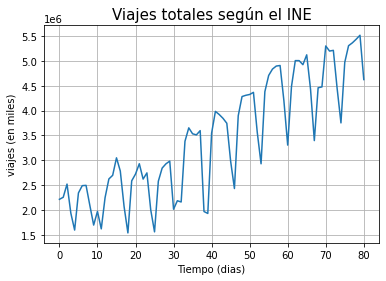

In [20]:
plt.plot(df.values)
plt.grid(True)
plt.title("Viajes totales según el INE", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

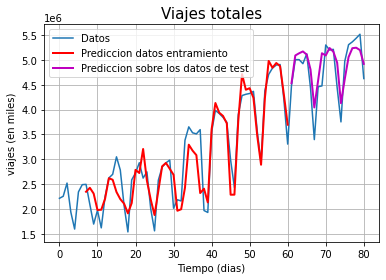

In [21]:
dataset = df.values
dataset = dataset.astype('float32')
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# predicciones del test de cambio para plotear
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back):len(dataset), :] = testPredict
# plot baseline and predictions
plt.plot(df.values)
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.title("Viajes totales", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

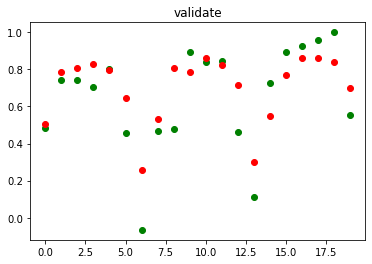

In [22]:
results=model.predict(x_val)

plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

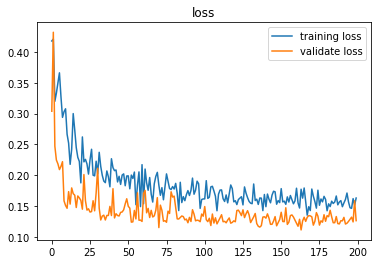

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.legend( ('training loss', 'validate loss'), loc = 'upper right')
plt.show()

# Prediccion a futuro

In [24]:
# usaremos los 14 ultimos dias del confinamiento en junio para predecir como habrian sido los dias del 21 al 27 en caso de que
# el confinamiento se hubiese alargado por una semana mas

ultimosDias = df['2020-6-7':'2020-6-20']
ultimosDias

,Viajes
2020-06-07,3396402
2020-06-08,4461143
2020-06-09,4478072
2020-06-10,5303428
2020-06-11,5200931
2020-06-12,5215302
2020-06-13,4445190
2020-06-14,3753016
2020-06-15,4973188
2020-06-16,5308885


# Preparamos los datos para el test

In [25]:
# cargamos el dataframe en la variable values
values = ultimosDias.values

# convertimos los enteros en floats
values = values.astype('float32')

# normalizamos los datos a escala de entre -1 y 1
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

# usamos la funcion definida previamente
reframed = series_to_supervised(scaled, look_back, 1)

# eliminamos la ultima columna pues es parte de lo que queremos hayar
reframed.drop(reframed.columns[[7]], inplace=True, axis=1)
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,-1.000000,0.002901,0.018846,0.796266,0.699721,0.713258,-0.012126
8,0.002901,0.018846,0.796266,0.699721,0.713258,-0.012126,-0.664099
9,0.018846,0.796266,0.699721,0.713258,-0.012126,-0.664099,0.485206
10,0.796266,0.699721,0.713258,-0.012126,-0.664099,0.485206,0.801405
11,0.699721,0.713258,-0.012126,-0.664099,0.485206,0.801405,0.855810
12,0.713258,-0.012126,-0.664099,0.485206,0.801405,0.855810,0.924364
13,-0.012126,-0.664099,0.485206,0.801405,0.855810,0.924364,1.000000


In [26]:
values = reframed.values

#tomamos los valores para realizar el test
x_test = values[6:, :]

# reshape input to be 3D [samples, timesteps, features]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
x_test

(1, 1, 7)


array([[[-0.01212597, -0.6640985 ,  0.48520565,  0.80140543,
          0.8558097 ,  0.9243636 ,  1.        ]]], dtype=float32)

In [27]:
#definimos la funcion para realizar el desplazamiento que se hara en el array cada prediccion pues para hacer
#la siguiente prediccion eliminamos el dia mas antiguo, desplazamos un lugar el resto de dias y añadimos el ultimo dia que
#se ha predecido, esto es por que para predecir un dia se usan los 7 dias previos

def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

# Predicciones para la proxima semana

In [28]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

[[[-0.01212597 -0.6640985   0.48520565  0.80140543  0.8558097
    0.9243636   1.        ]]]
[[[-0.6640985   0.48520565  0.80140543  0.8558097   0.9243636
    1.          0.38265088]]]
[[[ 0.48520565  0.80140543  0.8558097   0.9243636   1.
    0.38265088 -0.12750041]]]
[[[ 0.80140543  0.8558097   0.9243636   1.          0.38265088
   -0.12750041  0.46928376]]]
[[[ 0.8558097   0.9243636   1.          0.38265088 -0.12750041
    0.46928376  0.8026055 ]]]
[[[ 0.9243636   1.          0.38265088 -0.12750041  0.46928376
    0.8026055   0.85174483]]]
[[[ 1.          0.38265088 -0.12750041  0.46928376  0.8026055
    0.85174483  0.88141495]]]


# Re-Convertimos los resultados

In [29]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([0.38265088], dtype=float32), array([-0.12750041], dtype=float32), array([0.46928376], dtype=float32), array([0.8026055], dtype=float32), array([0.85174483], dtype=float32), array([0.88141495], dtype=float32), array([0.8694366], dtype=float32)]


array([[4864309.40993501],
       [4322701.43315565],
       [4956284.19828213],
       [5310159.05822305],
       [5362328.38193193],
       [5393828.00444817],
       [5381111.07486909]])

# Visualizamos el pronostico

<AxesSubplot:>

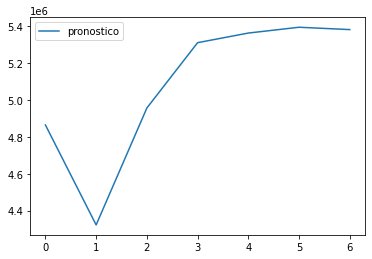

In [30]:
prediccion = pd.DataFrame(inverted)
prediccion.columns = ['pronostico']
prediccion.plot()

# Prediccion con datos actuales

In [31]:
# usaremos 14 dias que poseemos para predecir los 7 dias siguientes tras esto compararemos los resultados con los que
# poseemos para ver el grado de error

Dias = df['2020-5-11':'2020-5-24']
Dias

,Viajes
2020-05-11,3545526
2020-05-12,3985384
2020-05-13,3922169
2020-05-14,3845239
2020-05-15,3745419
2020-05-16,2983259
2020-05-17,2430478
2020-05-18,3896788
2020-05-19,4284420
2020-05-20,4309613


# Preparamos los datos para el test

In [32]:
# cargamos el dataframe en la variable values
values = Dias.values

# convertimos los enteros en floats
values = values.astype('float32')

# normalizamos los datos a escala de entre -1 y 1
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

# usamos la funcion definida previamente
reframed = series_to_supervised(scaled, look_back, 1)

# eliminamos la ultima columna pues es parte de lo que queremos hayar
reframed.drop(reframed.columns[[7]], inplace=True, axis=1)
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,0.150527,0.604381,0.539155,0.459777,0.356781,-0.429630,-1.000000
8,0.604381,0.539155,0.459777,0.356781,-0.429630,-1.000000,0.512966
9,0.539155,0.459777,0.356781,-0.429630,-1.000000,0.512966,0.912932
10,0.459777,0.356781,-0.429630,-1.000000,0.512966,0.912932,0.938927
11,0.356781,-0.429630,-1.000000,0.512966,0.912932,0.938927,0.955663
12,-0.429630,-1.000000,0.512966,0.912932,0.938927,0.955663,1.000000
13,-1.000000,0.512966,0.912932,0.938927,0.955663,1.000000,0.169306


In [33]:
values = reframed.values

#tomamos los valores para realizar el test
x_test = values[6:, :]

# reshape input to be 3D [samples, timesteps, features] - preguntar
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
x_test

(1, 1, 7)


array([[[-1.        ,  0.51296616,  0.9129319 ,  0.9389267 ,
          0.9556627 ,  1.        ,  0.16930556]]], dtype=float32)

In [34]:
#en la linea 24 definimos la funcion para realizar el desplazamiento que se hara en el array cada prediccion pues para hacer
#la siguiente prediccion eliminamos el dia mas antiguo, desplazamos un lugar el resto de dias y añadimos el ultimo dia que
#se ha predecido, esto es por que para predecir un dia se usan los 7 dias previos, y que usaremos a continuación

# Realizamos la prediccion 

In [35]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

[[[-1.          0.51296616  0.9129319   0.9389267   0.9556627
    1.          0.16930556]]]
[[[ 0.51296616  0.9129319   0.9389267   0.9556627   1.
    0.16930556 -0.3307109 ]]]
[[[ 0.9129319   0.9389267   0.9556627   1.          0.16930556
   -0.3307109   0.42423144]]]
[[[ 0.9389267   0.9556627   1.          0.16930556 -0.3307109
    0.42423144  0.8254161 ]]]
[[[ 0.9556627   1.          0.16930556 -0.3307109   0.42423144
    0.8254161   0.86272395]]]
[[[ 1.          0.16930556 -0.3307109   0.42423144  0.8254161
    0.86272395  0.88247216]]]
[[[ 0.16930556 -0.3307109   0.42423144  0.8254161   0.86272395
    0.88247216  0.86390275]]]


# Re-Convertimos los resultados

In [36]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)

#en nuestro problema no tienen sentido los decimales pues no se pueden hacer 0.5 viajes o 0.25 viajes
inverted = inverted.round()
inverted = inverted.astype(int)
inverted

[array([-0.3307109], dtype=float32), array([0.42423144], dtype=float32), array([0.8254161], dtype=float32), array([0.86272395], dtype=float32), array([0.88247216], dtype=float32), array([0.86390275], dtype=float32), array([0.51568], dtype=float32)]


array([[3079128],
       [3810790],
       [4199603],
       [4235760],
       [4254899],
       [4236903],
       [3899418]])

# Visualizamos el pronostico

<AxesSubplot:>

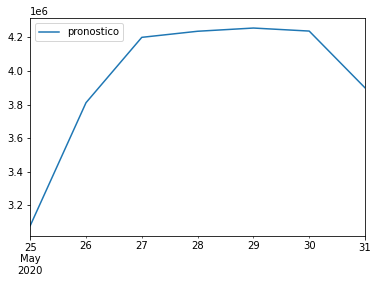

In [37]:
e_date = datetime.datetime.strptime('2020-05-31', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-05-25', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(inverted, index= index_days)
prediccion.columns = ['pronostico']
prediccion.plot()

In [38]:
datosReales = df['2020-5-25':'2020-5-31']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']
compara

,real,prediccion
2020-05-25,4382232,3079128
2020-05-26,4709433,3810790
2020-05-27,4837770,4199603
2020-05-28,4898946,4235760
2020-05-29,4909824,4254899
2020-05-30,4202334,4236903
2020-05-31,3305717,3899418


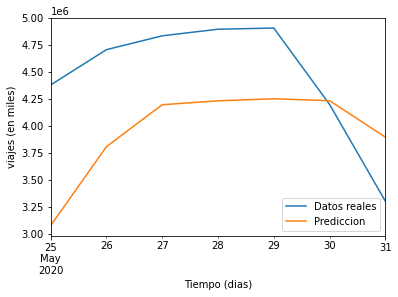

In [39]:
compara['real'].plot()
compara['prediccion'].plot()
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.legend( ('Datos reales', 'Prediccion'), loc = 'lower right')

In [40]:
# calculamos las metricas de error
testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion, datosReales)
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del test: 683756.43 MAE
Resultado del test: 590759245076.71 MSE
Resultado del test: 768608.64 RMSE
Resultado del test: 19.41 CVRMSE
Resultado del test: 18.31 MAPE


In [41]:
# calculamos las metricas de error para cada dia por separado
for i in range(7):
    testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion.values[i], datosReales.values[i])
    day = i + 1
    print('Resultado del test dia %d: %.2f MAE' % (day, testScore_MAE))
    print('Resultado del test dia %d: %.2f MSE' % (day, testScore_MSE))
    print('Resultado del test dia %d: %.2f RMSE' % (day, testScore_RMSE))
    print('Resultado del test dia %d: %.2f CVRMSE' % (day, testScore_CVRMSE))
    print('Resultado del test dia %d: %.2f MAPE \n' % (day, testScore_MAPE))

Resultado del test dia 1: 1303104.00 MAE
Resultado del test dia 1: 1698080034816.00 MSE
Resultado del test dia 1: 1303104.00 RMSE
Resultado del test dia 1: 42.32 CVRMSE
Resultado del test dia 1: 42.32 MAPE 

Resultado del test dia 2: 898643.00 MAE
Resultado del test dia 2: 807559241449.00 MSE
Resultado del test dia 2: 898643.00 RMSE
Resultado del test dia 2: 23.58 CVRMSE
Resultado del test dia 2: 23.58 MAPE 

Resultado del test dia 3: 638167.00 MAE
Resultado del test dia 3: 407257119889.00 MSE
Resultado del test dia 3: 638167.00 RMSE
Resultado del test dia 3: 15.20 CVRMSE
Resultado del test dia 3: 15.20 MAPE 

Resultado del test dia 4: 663186.00 MAE
Resultado del test dia 4: 439815670596.00 MSE
Resultado del test dia 4: 663186.00 RMSE
Resultado del test dia 4: 15.66 CVRMSE
Resultado del test dia 4: 15.66 MAPE 

Resultado del test dia 5: 654925.00 MAE
Resultado del test dia 5: 428926755625.00 MSE
Resultado del test dia 5: 654925.00 RMSE
Resultado del test dia 5: 15.39 CVRMSE
Resultado d